In [ ]:
# ensure python version is more than 3.5
import sys
assert sys.version_info >= (3,5)

# ensure scikit version is >=0.20
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

##Data generation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# generate some data for classification
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
# split the data for test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##Hard voting

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

# initialize three classifiers
lr_clf = LogisticRegression(solver='lbfgs',random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100,random_state=42)
svm_clf = SVC(gamma='scale',random_state=42)

# democratic voting classifier
voting_clf = VotingClassifier(estimators=[('lr',lr_clf),('rf',rf_clf),('svm',svm_clf)],voting='hard')

In [ ]:
voting_clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (lr_clf, rf_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

##Soft voting

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

# initialize three classifiers
lr_clf = LogisticRegression(solver='lbfgs',random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100,random_state=42)
svm_clf = SVC(gamma='scale',probability=True, random_state=42)

# democratic voting classifier
voting_clf = VotingClassifier(estimators=[('lr',lr_clf),('rf',rf_clf),('svm',svm_clf)],voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (lr_clf, rf_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

##Bagging ensembles

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print('accuracy_score : {}'.format(accuracy_score(y_pred, y_test)))

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
print('accuracy_score: {}'.format(accuracy_score(y_pred, y_test)))

## Random Forests

In [ ]:
# create a manual random forest
rf_clf = BaggingClassifier(DecisionTreeClassifier(max_features='sqrt'),
                           n_estimators=500, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print('accuracy_score: {}'.format(accuracy_score(y_pred, y_test)))

## Feature Importance

In [ ]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

# Function to plot the feature importance
def plot_feature_importance(imp):
    plt.imshow(imp, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Feature Importance')
    plt.title('Feature Importance of Each Pixel')
    plt.show()

# load the data
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# set target as numerical type
mnist.target = mnist.target.astype(np.uint8)

# train a random forest classifier
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

# plot the feature importance
imp = rnd_clf.feature_importances_
reshaped_imp = imp.reshape(28, 28)
plot_feature_importance(reshaped_imp)

## Gradient Boosting Regressor

In [ ]:
# create a synthetic dataset for regression with just two features
from sklearn.datasets import make_regression

# n_features vs n_informative
X, y = make_regression(n_samples=1000, n_features=2, n_informative=2,
                       n_targets=1, noise=0.1, random_state=42)

# Transform y to make the task non-linear
# For a cubic regression task:
y = y**3 + 0.1 * np.random.randn(1000)

# normalize y
y = (y - y.mean()) / y.std()

# split the data for train, validation and test (0.8, 0.1, 0.1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5,
                                                random_state=42)

# print some X_train and y_train
print(X_train[:5])
print(y_train[:5])



In [ ]:
# train gradient boosting regressor using decision tree regressor without using prebuilt model
# vary number of trees
from sklearn.tree import DecisionTreeRegressor

learning_rate = 0.1 
num_trees = [5, 20, 100]
gb_regs = []

for n in num_trees:
    residuals = y_train
    models = []
    for idx in range(n):
        single_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
        single_reg.fit(X_train, residuals)
        # get residuals of y_train
        y_pred = single_reg.predict(X_train)
        residuals = residuals - learning_rate*y_pred
        models.append(single_reg)
    gb_regs.append(models)

# To make predictions with this model, you would need to sum up the predictions from all the trees in the ensemble:
def predict(X, models):
    predictions = np.zeros(X.shape[0])
    for model in models:
        predictions += learning_rate * model.predict(X)
    return predictions

# plot the predictions for both sizes of trees
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for idx, num in enumerate(num_trees):
    plt.subplot(1,len(num_trees),idx+1)
    plt.title('Prediction with {} trees'.format(num))
    plt.scatter(X_train[:, 0], y_train, c='b', label='train')
    # plot the fitted regression line
    y_pred = predict(X_train, gb_regs[idx])
    # Sort X_train and y_pred by the x-values
    sorted_indices = X_train[:, 0].argsort()
    X_train_sorted = X_train[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    plt.plot(X_train_sorted[:, 0], y_pred_sorted, c='r', label='prediction')
    plt.legend()



In [ ]:
# early stopping to find optimal number of trees
from sklearn.metrics import mean_squared_error
# import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# initialize the model
gb_reg = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

# initialize the variables
val_errors = []
min_val_error = float('inf')
error_going_up = 0
best_num_trees = 0

# train the model
for n_estimators in range(1, 120):
    gb_reg.n_estimators = n_estimators
    gb_reg.fit(X_train, y_train)
    y_pred = gb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    val_errors.append(val_error)

# find the best number of trees
for idx, val_error in enumerate(val_errors):
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
        best_num_trees = idx+1
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

print('best number of trees: {}'.format(best_num_trees))

# train the model with best number of trees
gb_reg = GradientBoostingRegressor(max_depth=2, n_estimators=best_num_trees,
                                   random_state=42)
gb_reg.fit(X_train, y_train)
y_pred = gb_reg.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print('test error: {}'.format(test_error))

# plot val_error with n_estimators and also plot the regression line 
# for best number of trees
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title('Validation error vs number of trees')
plt.plot(range(1, 120), val_errors, c='b')
plt.xlabel('n_estimators')
plt.ylabel('validation error')
plt.axvline(x=best_num_trees, c='r', linestyle='--')
plt.subplot(1,2,2)
plt.title('Prediction with {} trees'.format(best_num_trees))
plt.scatter(X_train[:, 0], y_train, c='b', label='train')
# plot the fitted regression line
y_pred = gb_reg.predict(X_train)
# Sort X_train and y_pred by the x-values
sorted_indices = X_train[:, 0].argsort()
X_train_sorted = X_train[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]
plt.plot(X_train_sorted[:, 0], y_pred_sorted, c='r', label='prediction')
plt.legend()
plt.show()


## Gradient Boosting Classifier - AdaBoost

In [ ]:
# train an adaboost classifier with decision tree as base estimator
from sklearn.ensemble import AdaBoostClassifier


# Function to plot the decision boundary for a binary classifier
def plot_decision_boundary(clf, X, y):
    # create a meshgrid
    x1s = np.linspace(np.min(X[:, 0]) - 0.5, np.max(X[:, 0]) + 0.5, 100)
    x2s = np.linspace(np.min(X[:, 1]) - 0.5, np.max(X[:, 1]) + 0.5, 100)
    
    # meshgrid function is used to create a rectangular grid out of two given one-dimensional arrays
    x1, x2 = np.meshgrid(x1s, x2s)
    # predict the output for the meshgrid
    y_pred = clf.predict(np.c_[x1.ravel(), x2.ravel()])
    y_pred = y_pred.reshape(x1.shape)

    # plot the contour for the decision boundary
    # coutourf function is used to plot the contour for the decision boundary
    # it takes the x1, x2 and y_pred as input
    # cmap is the color map to use for the contour
    # alpha is the transparency of the contour
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.brg, alpha=0.2)
    # plot the actual data
    plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], c='b', marker='^')
    plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], c='r', marker='o')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

# algorithm is the hyperparameter that controls the boosting algorithm to use (SAMME or SAMME.R)
# SAMME.R relies on class probabilities rather than predictions and generally performs better
# SAMME is the default algorithm and relies on class predictions
# learning rate is the hyperparameter that controls how much each classifier is allowed to learn from the previous one

# train an adaboost classifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,
                             algorithm="SAMME.R", learning_rate=0.5, random_state=42)

ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y)

## XGBoost

XGBoost is a gradient boosting algorithm built on decision trees. 
It works fast even with large datasets because it evaluates best split for each feature in parallel. 
Also it uses a column block structure in memory. Column-wise storage is helpful because all instances of a feature 
are stored in a contiguous memory. It also supports distributed computing and can handle missing values. 

In [ ]:
# download covertype dataset
import os
import urllib.request


DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/"
COVER_PATH = os.path.join("datasets", "covertype")

def fetch_covertype_data(cover_path=COVER_PATH):
    if not os.path.isdir(cover_path):
        os.makedirs(cover_path)
    for filename in ("covtype.data.gz", "covtype.info"):
        url = DOWNLOAD_ROOT + filename
        urllib.request.urlretrieve(url, os.path.join(cover_path, filename))

fetch_covertype_data()

In [ ]:
# load the data
import pandas as pd

def load_covertype_data(cover_path=COVER_PATH):
    csv_path = os.path.join(cover_path, "covtype.data.gz")
    return pd.read_csv(csv_path, header=None)

cover = load_covertype_data()

# keep header names as per the info file

cover.columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                    'Horizontal_Distance_To_Fire_Points'] + \
                    ['Wilderness_Area_{}'.format(i) for i in range(4)] + \
                    ['Soil_Type_{}'.format(i) for i in range(40)] + \
                    ['Cover_Type']

# print the first five rows
print(cover.head())

# split into X and Y
X = cover.drop(['Cover_Type'], axis=1)
y = cover['Cover_Type']

Number of missing features - Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area_0                     0
Wilderness_Area_1                     0
Wilderness_Area_2                     0
Wilderness_Area_3                     0
Soil_Type_0                           0
Soil_Type_1                           0
Soil_Type_2                           0
Soil_Type_3                           0
Soil_Type_4                           0
Soil_Type_5                           0
Soil_Type_6                           0
Soil_Type_7                           0
Soil_Type_8                           0
Soil_Type_9                           0
Soil_Type_1

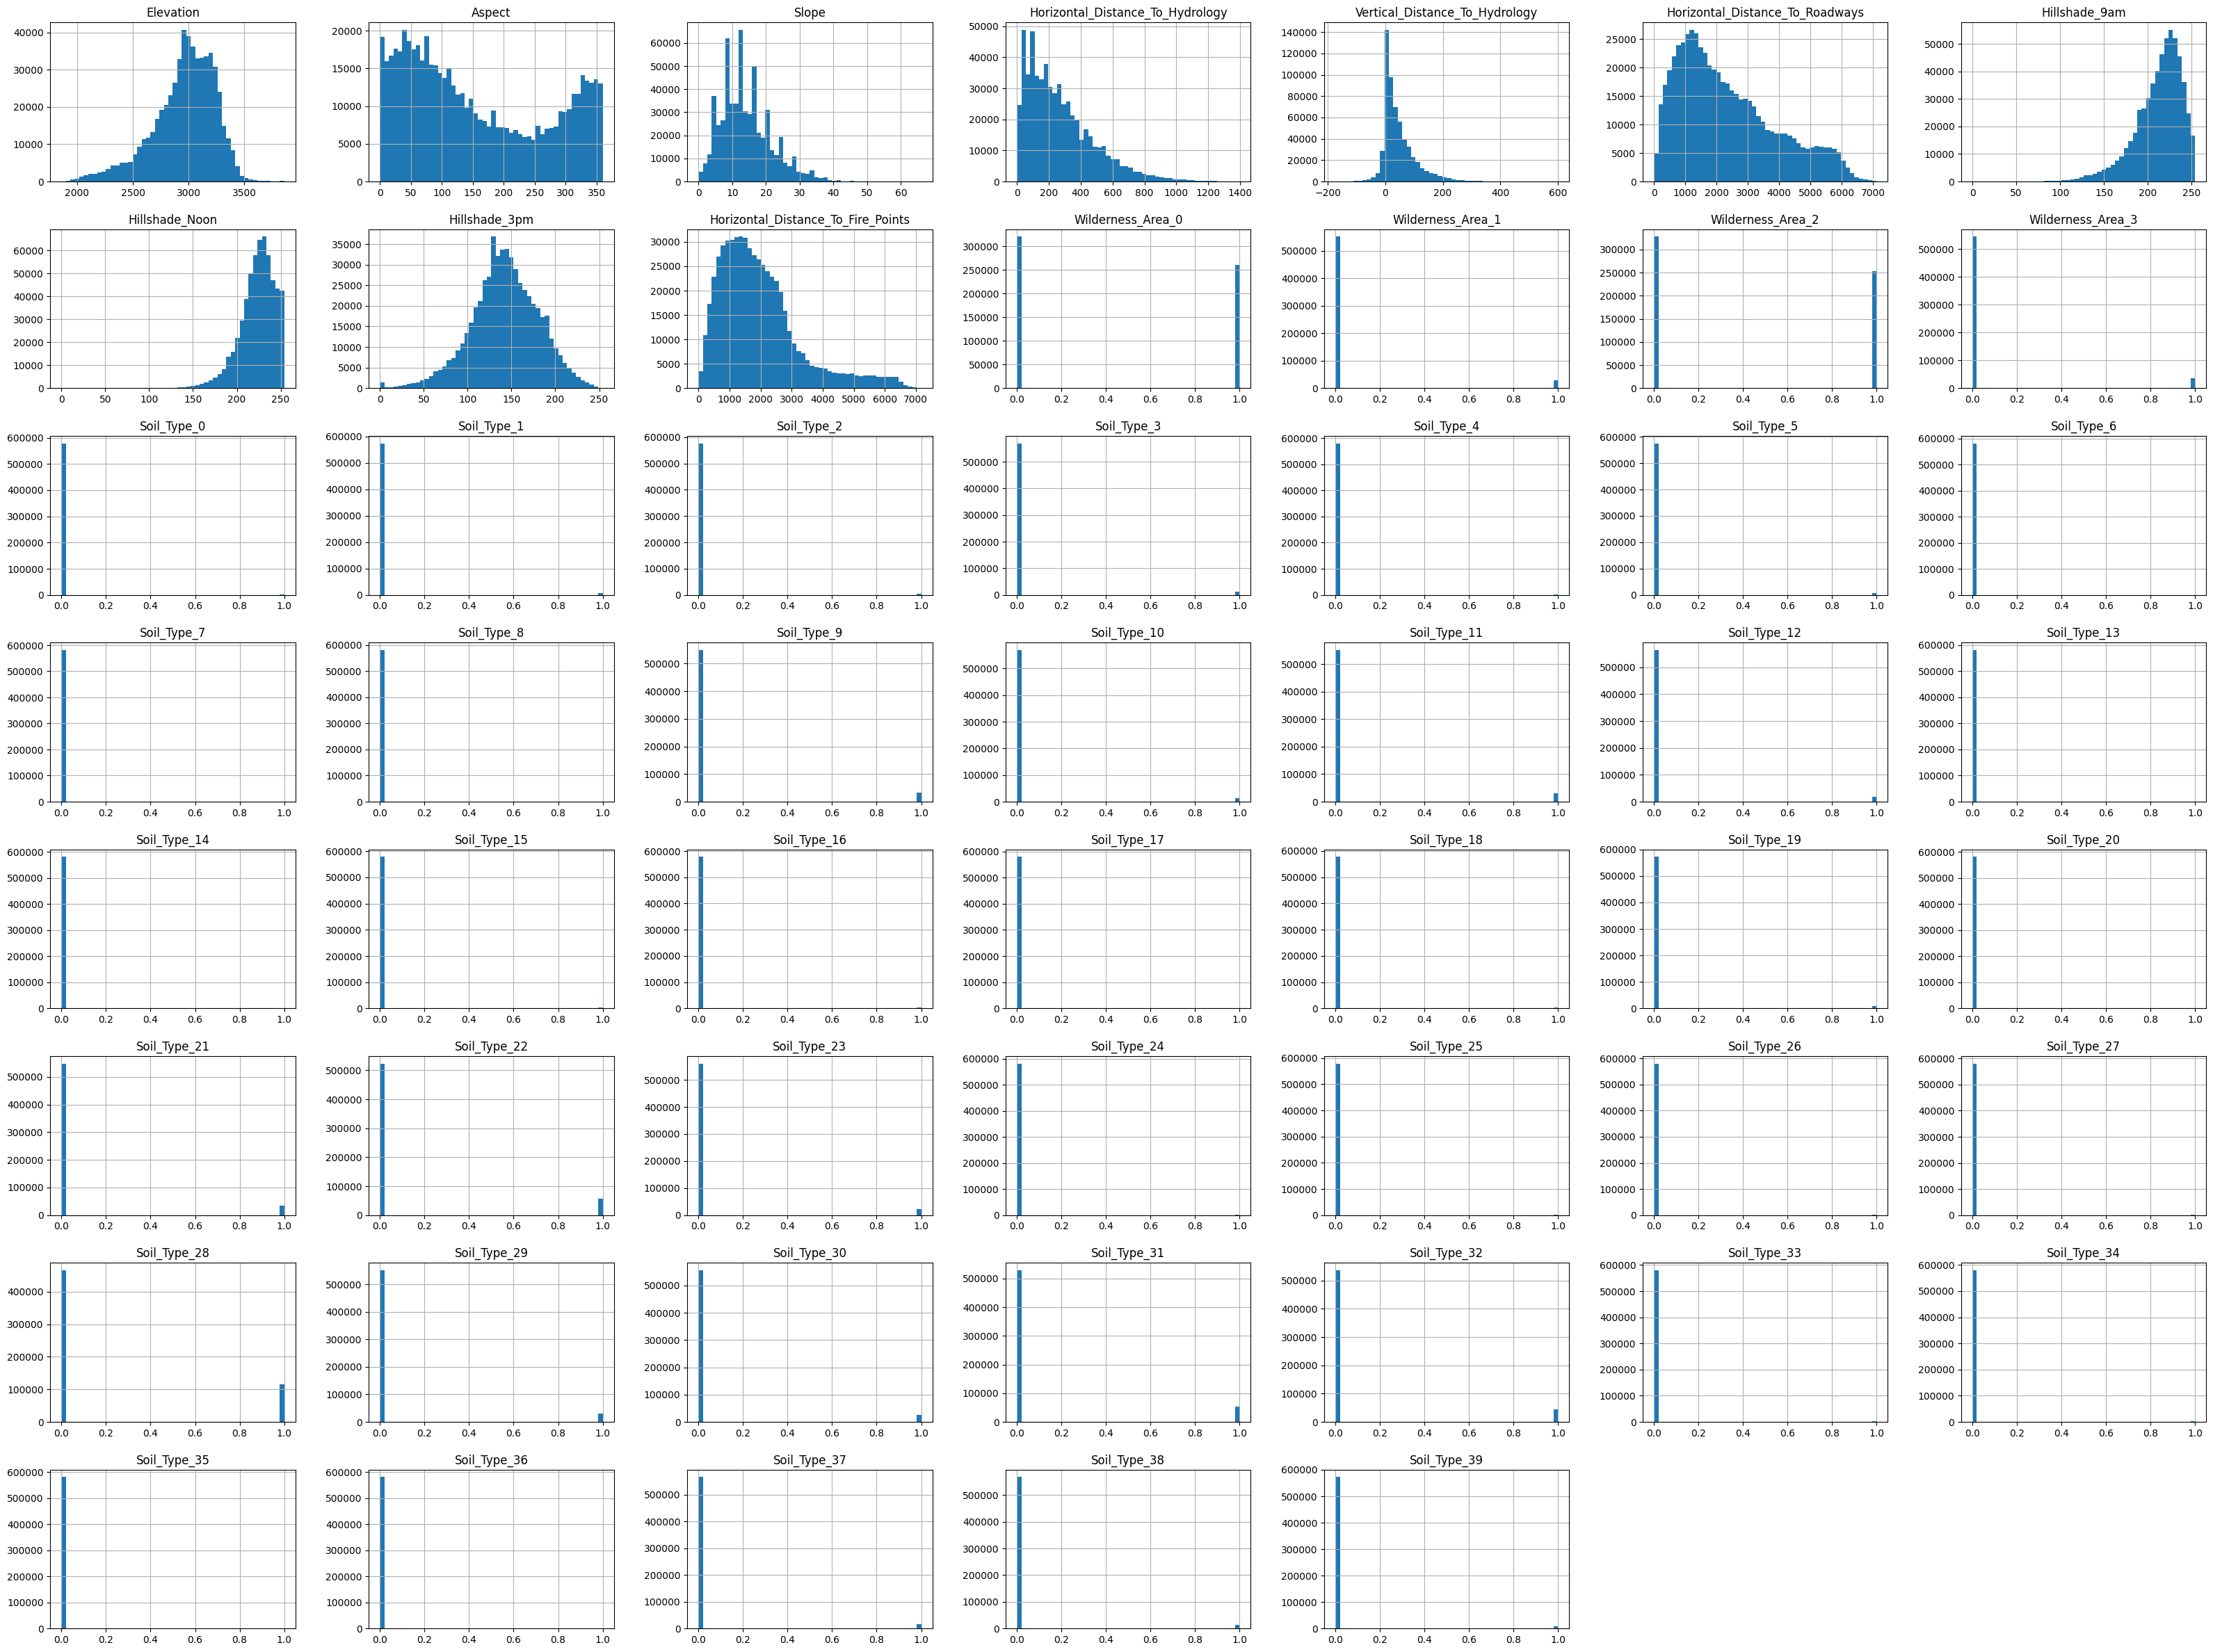

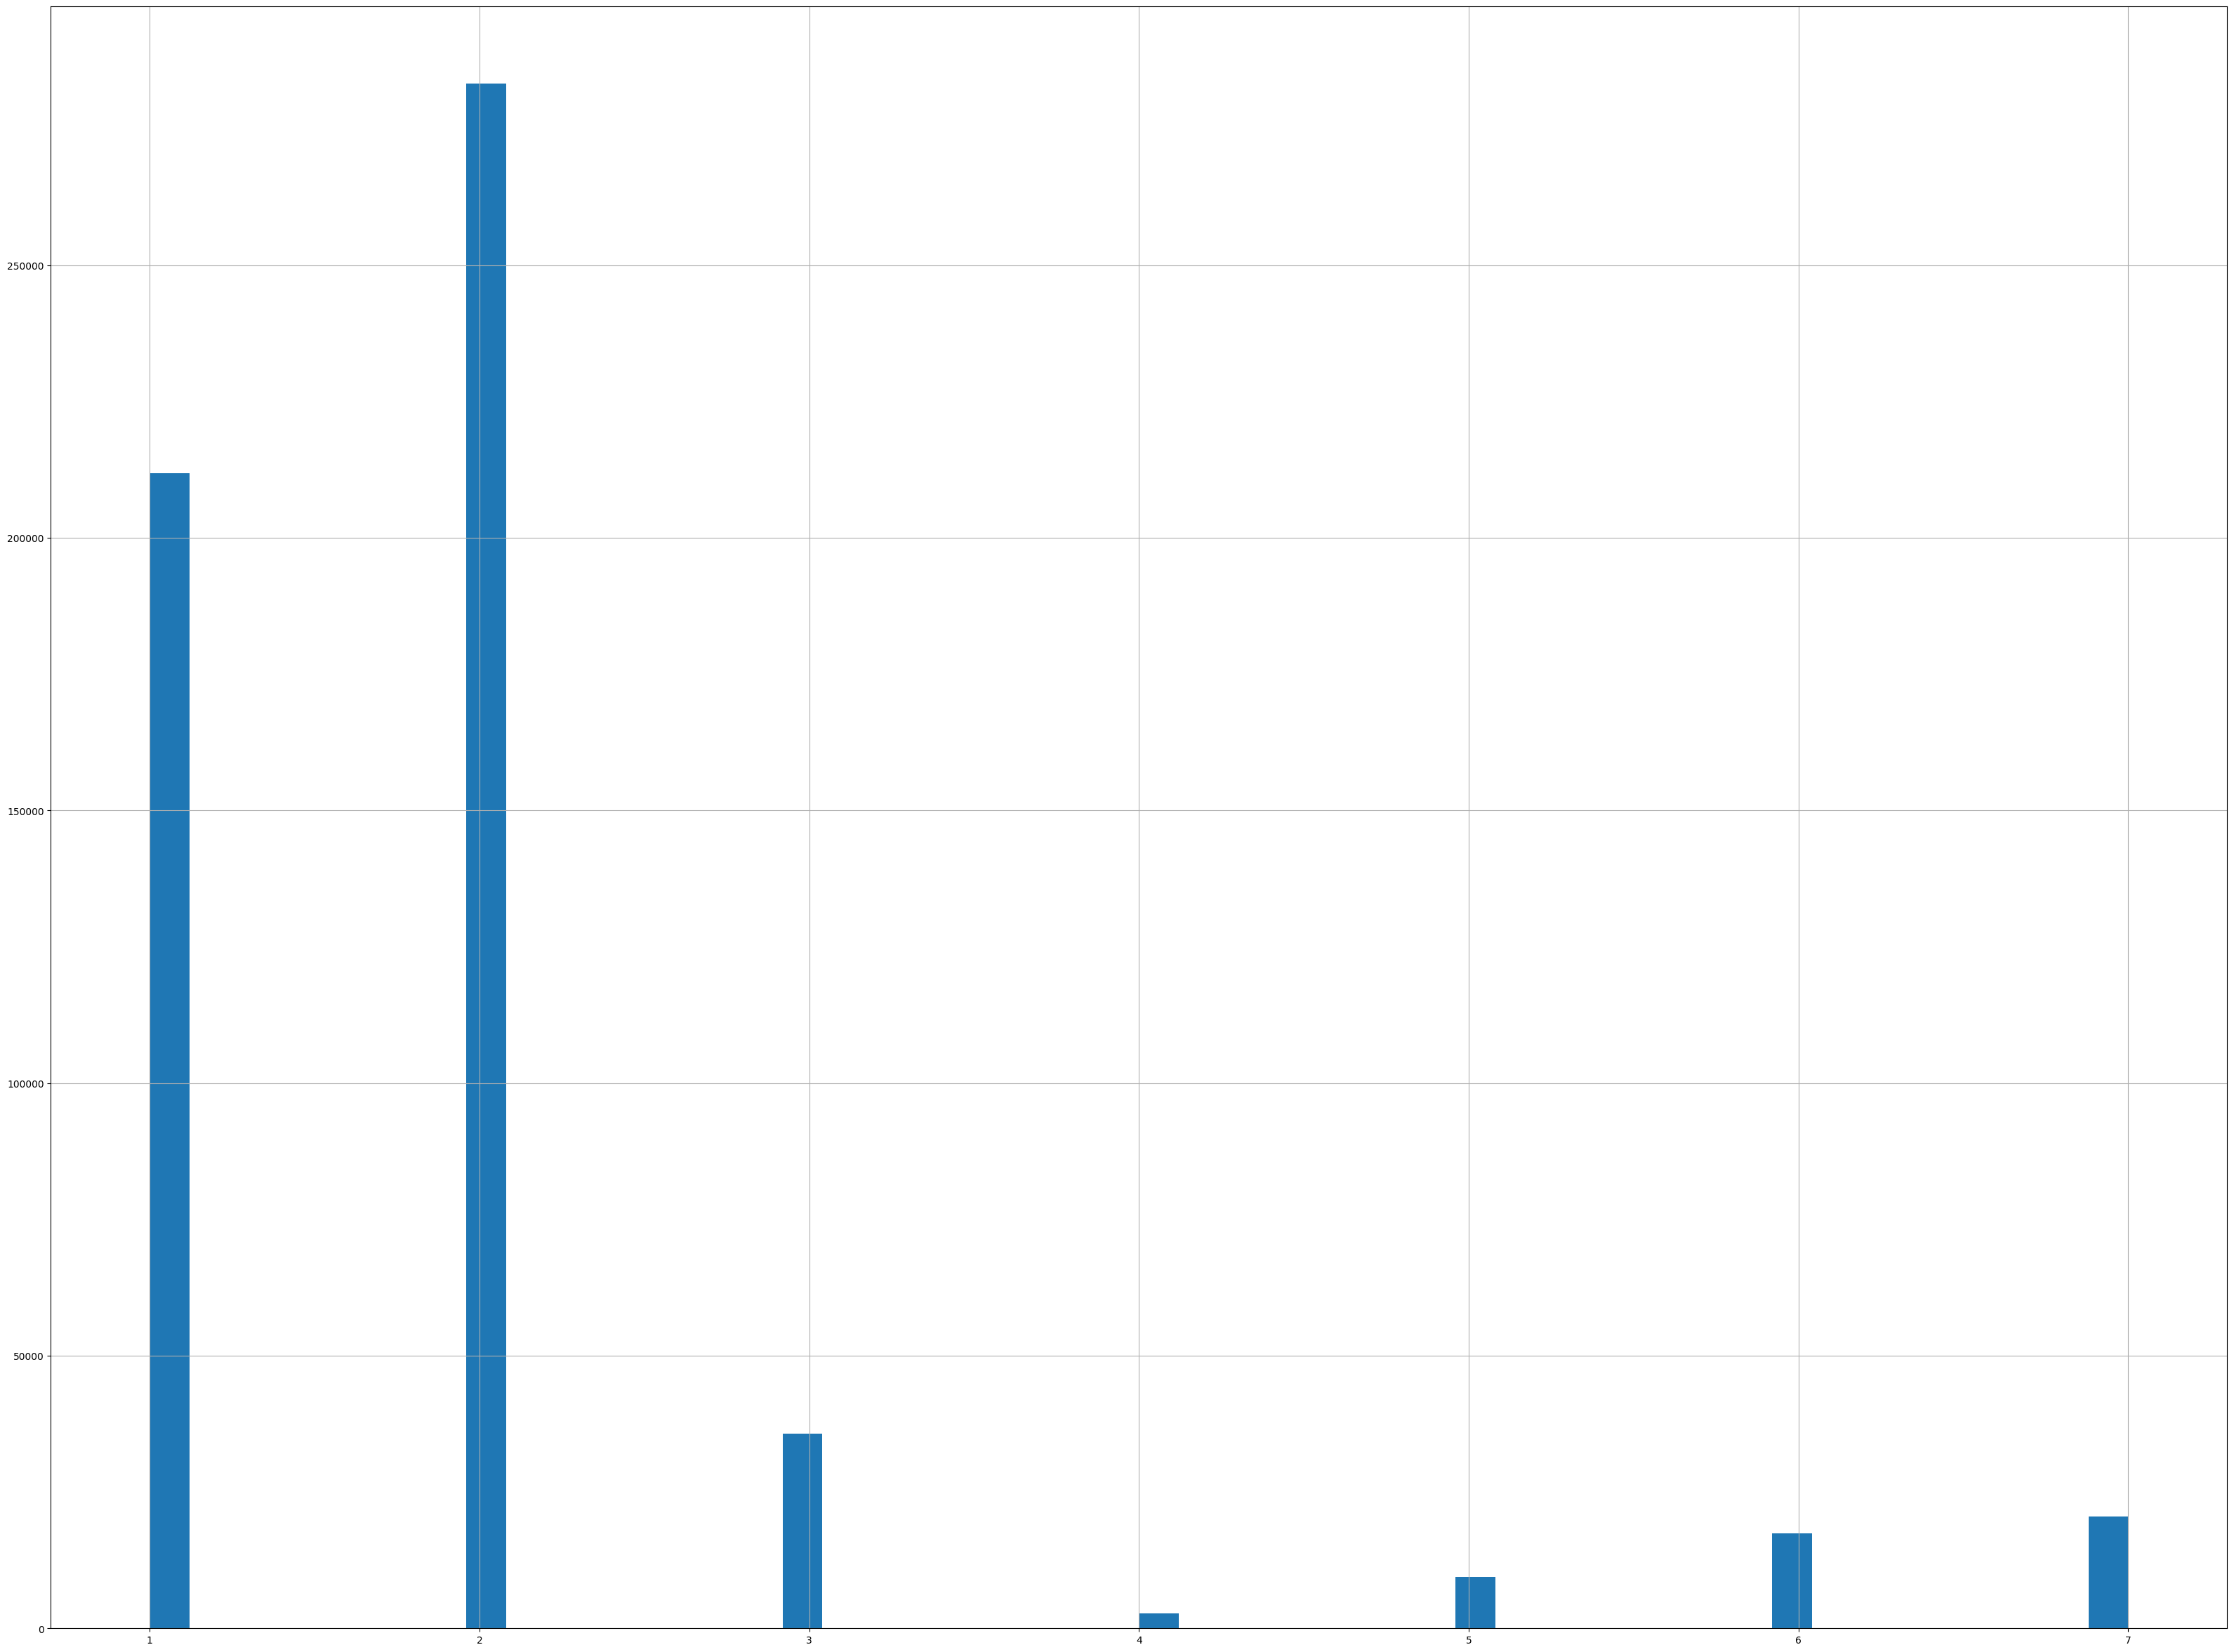

Summary of the data
           Elevation         Aspect          Slope  \
count  581012.000000  581012.000000  581012.000000   
mean     2959.365301     155.656807      14.103704   
std       279.984734     111.913721       7.488242   
min      1859.000000       0.000000       0.000000   
25%      2809.000000      58.000000       9.000000   
50%      2996.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     581012.000000                   581012.000000   
mean                         269.428217                       46.418855   
std                          212.549356                       58.295232   
min                            0.000000                     -173.000000   
25%                          108.000000                        7.000000   
50%                          218.000000    

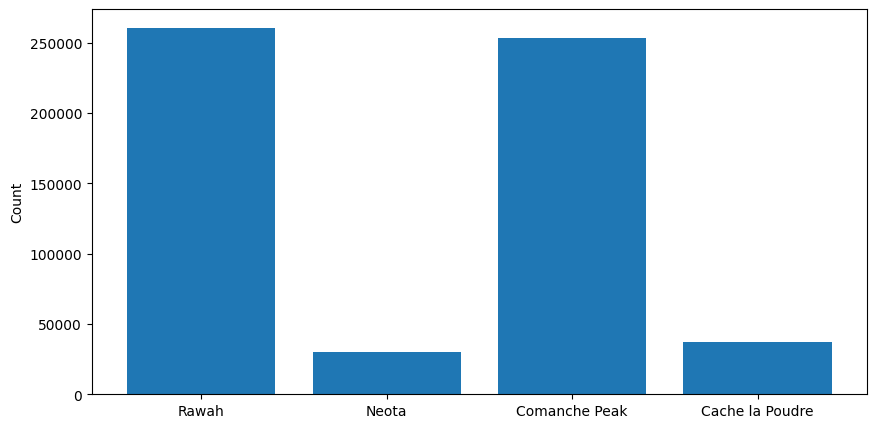

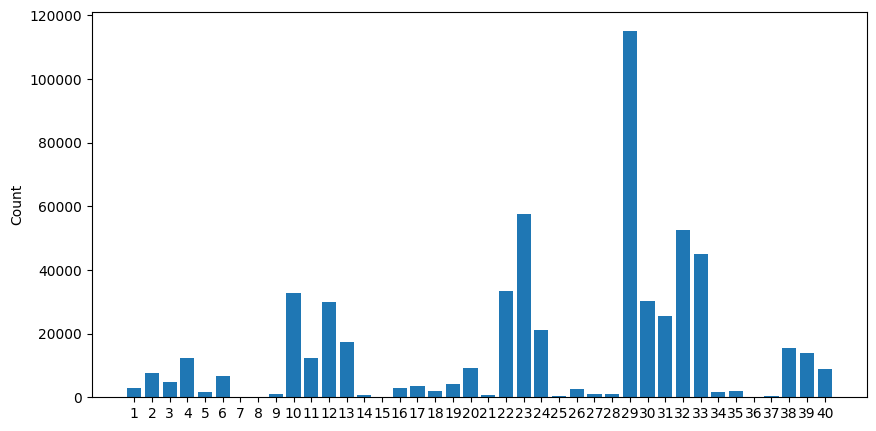

In [71]:
# data exploration
import matplotlib.pyplot as plt
# check if there is missing data
print("Number of missing features - {}".format(X.isnull().sum()))

# check all the unique data types
print("Unique datatypes {}".format(X.dtypes.unique()))

# everything is int64, so no need to convert

# check the distribution of the data
X.hist(bins=50, figsize=(40,30))
plt.show()

y.hist(bins=50, figsize=(40,30))
plt.show()


# get statistical summary of the data
print("Summary of the data")
print(X.iloc[:,0:9].describe())

# plot a histogram of the wilderness area 
plt.figure(figsize=(10, 5))
plt.bar(range(4), X.iloc[:,10:14].sum())
plt.xticks(range(4), ['Rawah', 'Neota', 'Comanche Peak', 'Cache la Poudre'])
plt.ylabel('Count')
plt.show()

# plot a histogram of the soil type
plt.figure(figsize=(10, 5))
plt.bar(range(40), X.iloc[:,14:54].sum())
plt.xticks(range(40), range(1,41))
plt.ylabel('Count')
plt.show()


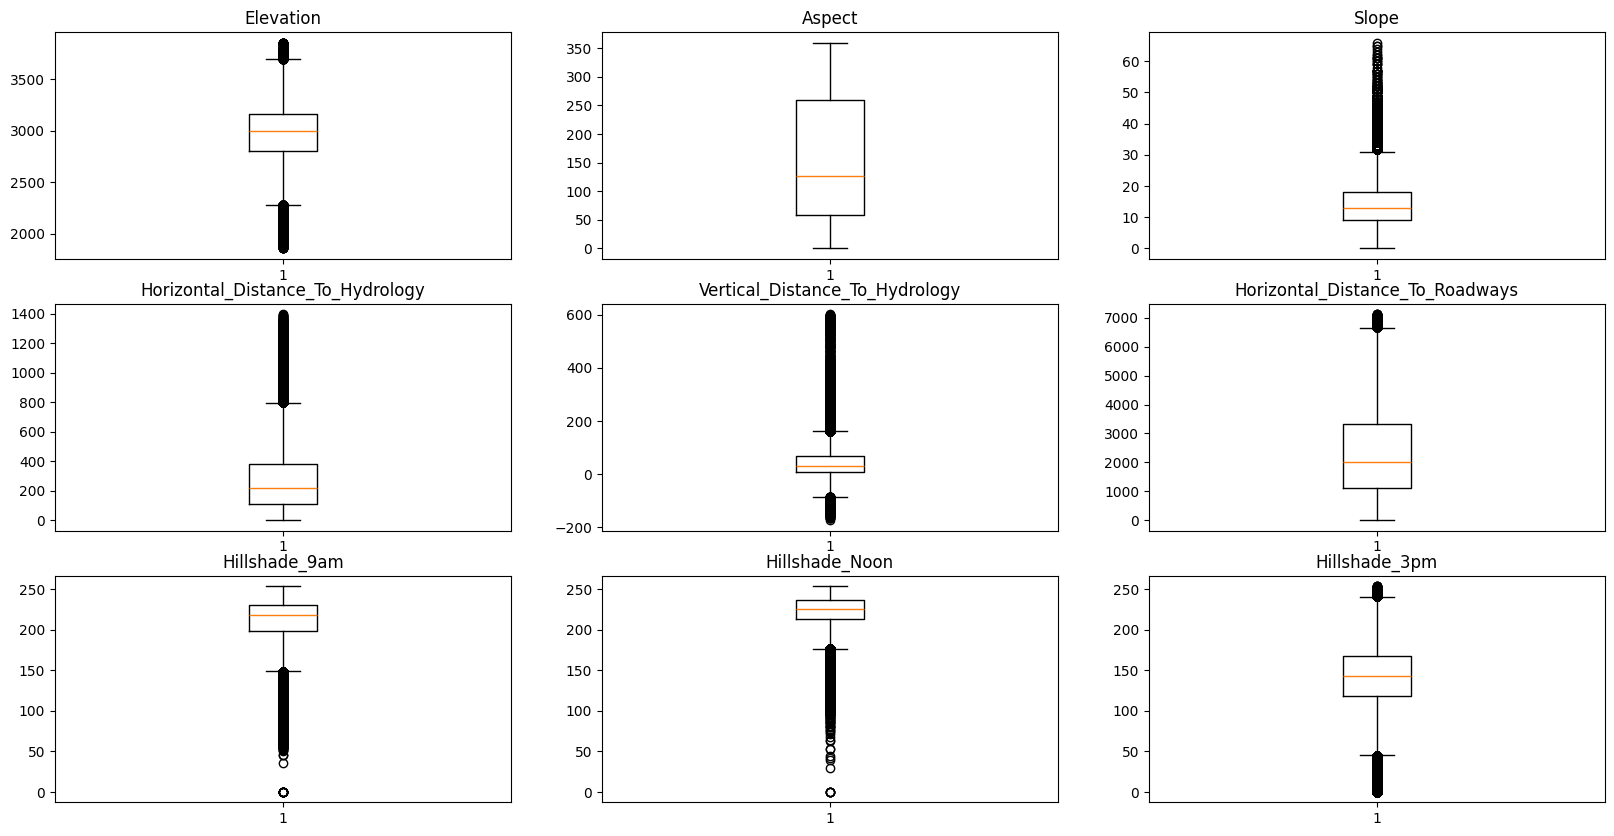

Number of outliers for each feature
Elevation                            5832
Aspect                                  0
Slope                                4074
Horizontal_Distance_To_Hydrology     7073
Vertical_Distance_To_Hydrology      10059
Horizontal_Distance_To_Roadways        33
Hillshade_9am                        7516
Hillshade_Noon                       7082
Hillshade_3pm                        3042
dtype: int64


In [78]:
# check if there are outliers in the data
# plot box plot for each feature separately
plt.figure(figsize=(20, 10))
for idx, col in enumerate(X.iloc[:,0:9].columns):
    plt.subplot(3,3,idx+1)
    plt.boxplot(X[col])
    plt.title(col)
plt.show()

# Calculate Z-score for each feature
from scipy import stats
z = np.abs(stats.zscore(X.iloc[:,0:9]))

# count the number of outliers for each feature
print("Number of outliers for each feature")
print(np.sum(z>3, axis=0))


In [80]:
# check if some soil types occur more than others
print("Soil type counts")
print(X.iloc[:,14:54].sum(axis=0))


Soil type counts
Soil_Type_0       3031
Soil_Type_1       7525
Soil_Type_2       4823
Soil_Type_3      12396
Soil_Type_4       1597
Soil_Type_5       6575
Soil_Type_6        105
Soil_Type_7        179
Soil_Type_8       1147
Soil_Type_9      32634
Soil_Type_10     12410
Soil_Type_11     29971
Soil_Type_12     17431
Soil_Type_13       599
Soil_Type_14         3
Soil_Type_15      2845
Soil_Type_16      3422
Soil_Type_17      1899
Soil_Type_18      4021
Soil_Type_19      9259
Soil_Type_20       838
Soil_Type_21     33373
Soil_Type_22     57752
Soil_Type_23     21278
Soil_Type_24       474
Soil_Type_25      2589
Soil_Type_26      1086
Soil_Type_27       946
Soil_Type_28    115247
Soil_Type_29     30170
Soil_Type_30     25666
Soil_Type_31     52519
Soil_Type_32     45154
Soil_Type_33      1611
Soil_Type_34      1891
Soil_Type_35       119
Soil_Type_36       298
Soil_Type_37     15573
Soil_Type_38     13806
Soil_Type_39      8750
dtype: int64


soil_type_14 exists only in three instances out of 500k. 
There seem to be many outliers that are outside the median +/- 1.5*IQR. Should we remove those features?